# Analyzing Real User Data in Government

Using the "weekly snapshot" data export from site scanning the week of July 22, 2024, we created a list of unique origins from the site scanning report. This is then fed into BigQuery where a report was created that contains origins from the site scanning report who were 1) eligible for the Chrome User Experience Report (CrUX) and 2) contained enough data to be reported in the CrUX report.

In [202]:
import os
import pandas as pd

notebook_dir = os.getcwd()


file_name = "data/site-scanning-weekly-snapshot-20240722.csv"
file_path = os.path.join(notebook_dir, file_name)

df = pd.read_csv(file_path)
final_url_website_data = df["final_url_website"].unique()
final_url_website_list = final_url_website_data.astype(str).tolist()
final_url_website_str = ", ".join(
    "'https://" + str(url) + "'" for url in final_url_website_list
)

## Use this in the sql query 'where in' clause
# print(final_url_website_str)

## Methodology

Trends among the origins from the site scanning report, hereafter referred to as US government sites, were examined against Google's Core Web Vitals (CWV) metrics among real users over a 6-month period. The US government sites were then compared to all other sites from the CrUX dataset. 

The 3 CWV metrics with their corresponding parameters for achieving a qualitative score of "good" are as follows:
- Largest Contentful Paint (LCP) - within the first 2.5 seconds
- Cumulative Layout Shift (CLS) - less than 0.1
- Interaction to Next Paint (INP) - less than 200ms

In [203]:
import matplotlib.pyplot as plt


def plot_cwv_results(df, percentile):

    plt.figure(figsize=(20, 6))
    pos = list(range(len(df.index)))
    width = 0.2
    edgecolor = "#808080"

    # 942ddb, #725ffc, #2588fe, #009ff4, #00bbdf, #00d2ad, #2ddb69
    bars1 = plt.bar(
        pos,
        df["pct_good_cls"] * 100,
        width,
        alpha=1,
        color="#942ddb",
        edgecolor=edgecolor,
    )
    bars2 = plt.bar(
        [p + width for p in pos],
        df["pct_good_lcp"] * 100,
        width,
        alpha=1,
        color="#009ff4",
        edgecolor=edgecolor,
    )
    bars3 = plt.bar(
        [p + 2 * width for p in pos],
        df["pct_good_inp"] * 100,
        width,
        alpha=1,
        color="#2ddb69",
        edgecolor=edgecolor,
    )

    plt.title("Core Web Vitals By Month")
    plt.xlabel("Month")
    plt.ylabel(f'% achieving a "good" rating')
    plt.ylim([0, 100])

    plt.xticks([p + 1.5 * width for p in pos], df.index)

    plt.legend(
        [bars1, bars2, bars3],
        [
            "CLS",
            "LCP",
            "INP",
        ],
        loc="lower left",
    )
    plt.grid()
    plt.show()

In [204]:
def load_results_to_dataframe(file_name):
    file_path = os.path.join(notebook_dir, file_name)
    df = pd.read_csv(file_path)
    df = df[df["client"] == "mobile"].sort_values(by="date", ascending=True)
    df.reset_index()
    df.set_index("date", inplace=True)
    return df

## US Government Sites

Here are the CWV metrics from origins that are found in the site scanning report. From the data below, the metric that is least likely to achieve a qualitative score of "good" is Largest Contentful Paint (LCP). 

In [205]:
dfInGov = load_results_to_dataframe("data/aggregate-cwv-in-government-p75.csv")
dfInGov.head(50)

,client,origins,origins_with_good_inp,origins_with_good_cls,origins_with_good_ttfb,origins_with_good_fcp,origins_with_good_lcp,origins_with_any_inp,origins_with_any_cls,origins_with_any_ttfb,origins_with_any_fcp,origins_with_any_lcp,origins_with_good_cwv,origins_eligible_for_cwv,pct_good_ttfb,pct_good_fcp,pct_good_lcp,pct_good_cls,pct_good_inp,pct_eligible_origins_with_good_cwv
date,,,,,,,,,,,,,,,,,,,,
2024-01-01,mobile,4394,2500,3147,1218,1579,2096,3365,3739,3704,3744,3695,1534,3694,0.328834,0.421741,0.567253,0.841669,0.742942,0.392502
2024-02-01,mobile,4375,2491,3153,1185,1531,2086,3359,3755,3724,3763,3707,1531,3705,0.318206,0.406856,0.562719,0.839680,0.741590,0.391304
2024-03-01,mobile,4462,2546,3197,1206,1644,2223,3369,3787,3754,3791,3736,1680,3735,0.321257,0.433659,0.595021,0.844204,0.755714,0.427498
2024-04-01,mobile,4516,2585,3236,1181,1606,2193,3390,3804,3771,3810,3756,1656,3756,0.313180,0.421522,0.583866,0.850683,0.762537,0.418863
2024-05-01,mobile,4559,2579,3247,1032,1466,2039,3385,3827,3792,3834,3767,1520,3766,0.272152,0.382368,0.541280,0.848445,0.761891,0.383768
2024-06-01,mobile,4564,2619,3202,1151,1686,2245,3368,3772,3745,3778,3738,1713,3738,0.307343,0.446268,0.600589,0.848887,0.777613,0.435156


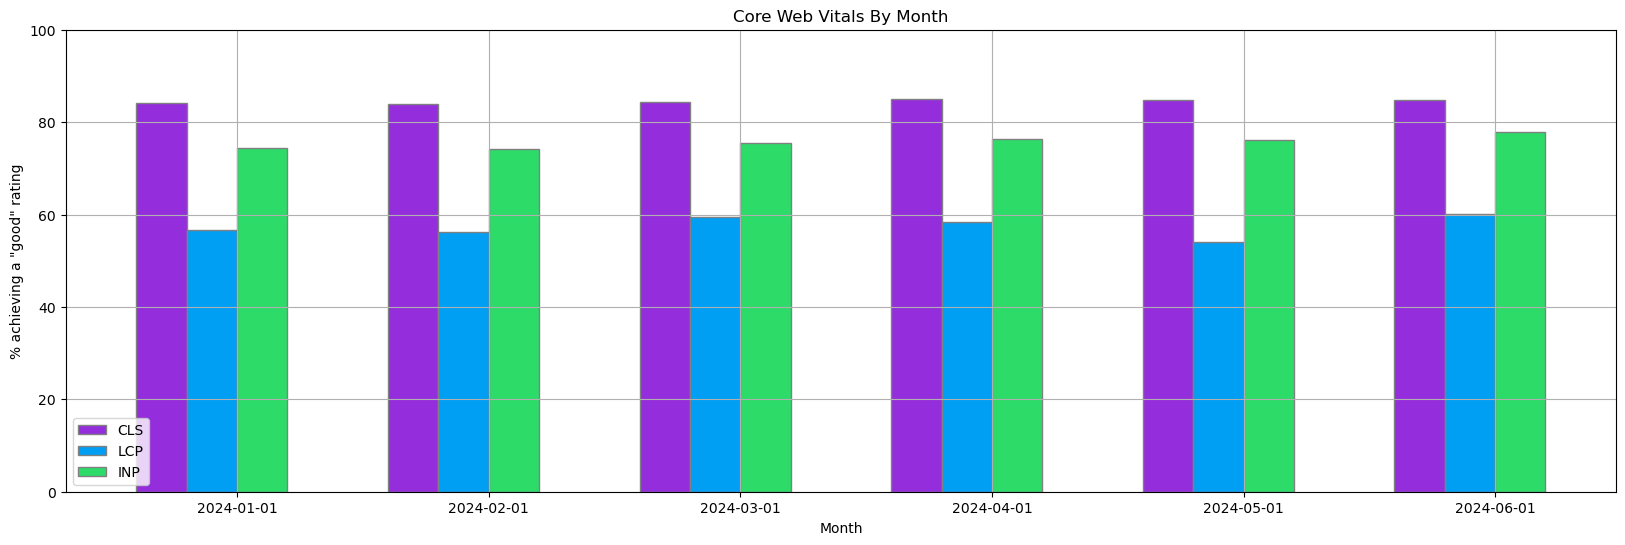

In [206]:
plot_cwv_results(dfInGov, "p75")

## All other sites

Here is the data for all other sites with the origins from the site scanning report excluded from the data set to capture how US government sites compare with the industry as a whole.

In [207]:
dfNotInGov = load_results_to_dataframe("data/aggregate-cwv-not-in-government-p75.csv")
dfNotInGov.head(50)

,client,origins,origins_with_good_inp,origins_with_good_cls,origins_with_good_ttfb,origins_with_good_fcp,origins_with_good_lcp,origins_with_any_inp,origins_with_any_cls,origins_with_any_ttfb,origins_with_any_fcp,origins_with_any_lcp,origins_with_good_cwv,origins_eligible_for_cwv,pct_good_ttfb,pct_good_fcp,pct_good_lcp,pct_good_cls,pct_good_inp,pct_eligible_origins_with_good_cwv
date,,,,,,,,,,,,,,,,,,,,
2024-01-01,mobile,17608211,5774939,8860195,4518624,5641224,6324949,8478610,11325194,10860991,11410444,11041708,4438693,11008175,0.416042,0.494391,0.572823,0.782344,0.681119,0.390258
2024-02-01,mobile,17772904,5705751,8770371,4448756,5533908,6225014,8428004,11214265,10779924,11301089,10927616,4363366,10893768,0.412689,0.489679,0.569659,0.782073,0.676999,0.387866
2024-03-01,mobile,17684179,5875508,8784696,4484632,5604823,6304298,8390686,11145597,10692326,11231373,10859885,4509516,10826134,0.419425,0.499033,0.580512,0.788176,0.700242,0.403989
2024-04-01,mobile,17718149,5976746,8837992,4474500,5637154,6331438,8383618,11157601,10695393,11243598,10868031,4589794,10833419,0.418358,0.501366,0.582575,0.792105,0.712908,0.411327
2024-05-01,mobile,17729471,6069417,8859176,4473477,5591686,6304496,8409052,11202836,10725682,11290942,10908351,4590487,10873137,0.417081,0.495236,0.577951,0.790798,0.721772,0.410513
2024-06-01,mobile,17550222,6166626,8830458,4460493,5734015,6416714,8346080,11131533,10644873,11219631,10838260,4718796,10802930,0.419027,0.511070,0.592043,0.793283,0.738865,0.425086


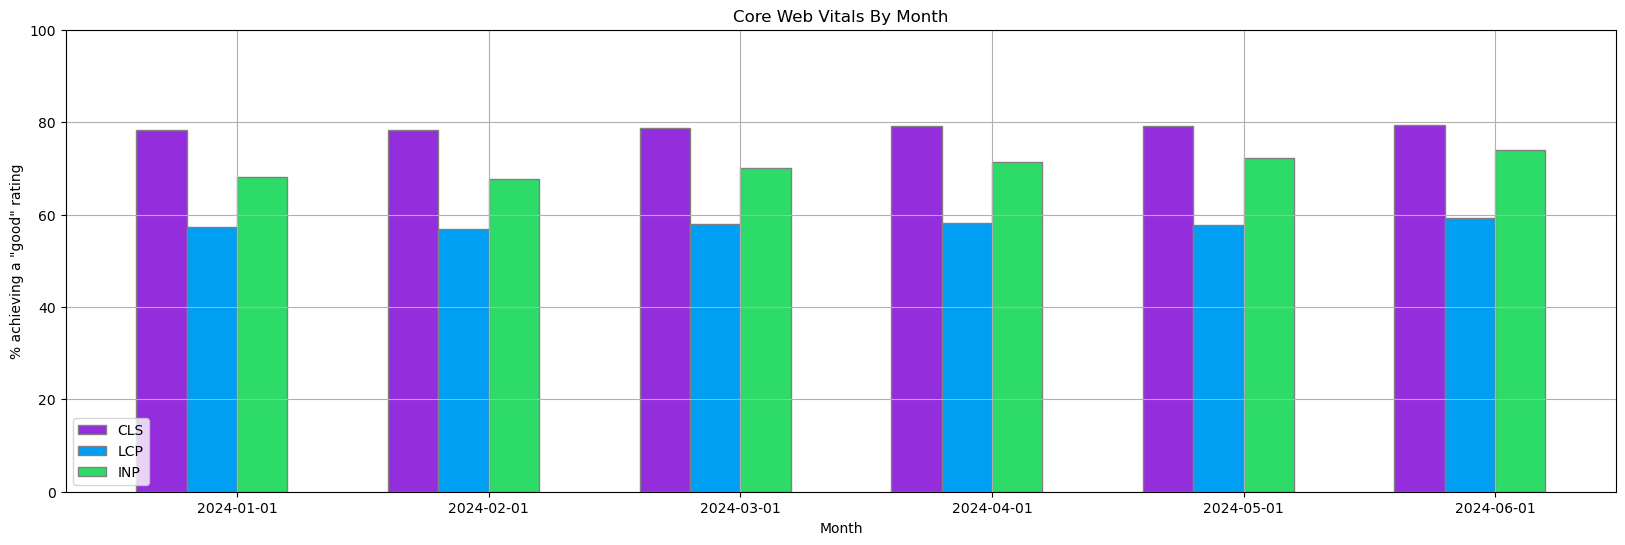

In [208]:
plot_cwv_results(dfNotInGov, "p75")

## Comparison of individual metrics

Here is a direct comparison of individual metrics between origins in the site scanning report vs. those origins not in the site scanning report.

In [209]:
merged_df = dfNotInGov.join(dfInGov, lsuffix="_dfNotInGov", rsuffix="_dfInGov")
merged_df.head(500)

,client_dfNotInGov,origins_dfNotInGov,origins_with_good_inp_dfNotInGov,origins_with_good_cls_dfNotInGov,origins_with_good_ttfb_dfNotInGov,origins_with_good_fcp_dfNotInGov,origins_with_good_lcp_dfNotInGov,origins_with_any_inp_dfNotInGov,origins_with_any_cls_dfNotInGov,origins_with_any_ttfb_dfNotInGov,...,origins_with_any_fcp_dfInGov,origins_with_any_lcp_dfInGov,origins_with_good_cwv_dfInGov,origins_eligible_for_cwv_dfInGov,pct_good_ttfb_dfInGov,pct_good_fcp_dfInGov,pct_good_lcp_dfInGov,pct_good_cls_dfInGov,pct_good_inp_dfInGov,pct_eligible_origins_with_good_cwv_dfInGov
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,mobile,17608211,5774939,8860195,4518624,5641224,6324949,8478610,11325194,10860991,...,3744,3695,1534,3694,0.328834,0.421741,0.567253,0.841669,0.742942,0.392502
2024-02-01,mobile,17772904,5705751,8770371,4448756,5533908,6225014,8428004,11214265,10779924,...,3763,3707,1531,3705,0.318206,0.406856,0.562719,0.839680,0.741590,0.391304
2024-03-01,mobile,17684179,5875508,8784696,4484632,5604823,6304298,8390686,11145597,10692326,...,3791,3736,1680,3735,0.321257,0.433659,0.595021,0.844204,0.755714,0.427498
2024-04-01,mobile,17718149,5976746,8837992,4474500,5637154,6331438,8383618,11157601,10695393,...,3810,3756,1656,3756,0.313180,0.421522,0.583866,0.850683,0.762537,0.418863
2024-05-01,mobile,17729471,6069417,8859176,4473477,5591686,6304496,8409052,11202836,10725682,...,3834,3767,1520,3766,0.272152,0.382368,0.541280,0.848445,0.761891,0.383768
2024-06-01,mobile,17550222,6166626,8830458,4460493,5734015,6416714,8346080,11131533,10644873,...,3778,3738,1713,3738,0.307343,0.446268,0.600589,0.848887,0.777613,0.435156


In [210]:
def plot_individual_metric_comparison(df, column1, column2, metric, percentile):
    width = 0.2
    edgecolor = "#808080"

    # Make the plot
    plt.figure(figsize=(10, 5))

    pos = list(range(len(df.index)))
    bars1 = plt.bar(
        pos, column1 * 100, width, alpha=1, color="#942ddb", edgecolor=edgecolor
    )
    bars2 = plt.bar(
        [p + width for p in pos],
        column2 * 100,
        width,
        alpha=1,
        color="#2ddb69",
        edgecolor=edgecolor,
    )

    # Adding title and labels to the axes
    plt.xlabel("Date", fontweight="bold", fontsize=15)
    plt.ylabel(
        f'% of origins achieving a "good" rating', fontweight="bold", fontsize=15
    )
    plt.title(f"{metric} at {percentile}", fontweight="bold", fontsize=20)
    plt.xticks([r + width for r in range(len(bars1))], df.index)

    # Create legend
    plt.legend([bars1, bars2], ["US government", "All others"], loc="lower left")

    plt.grid()
    plt.show()

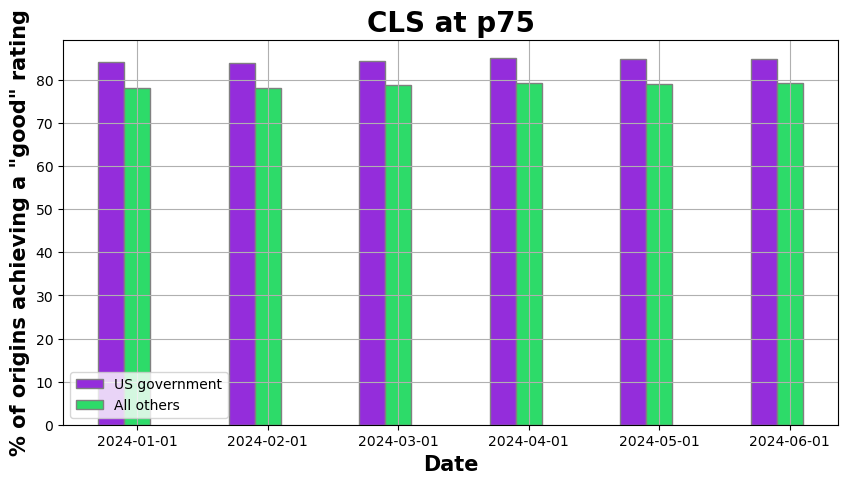

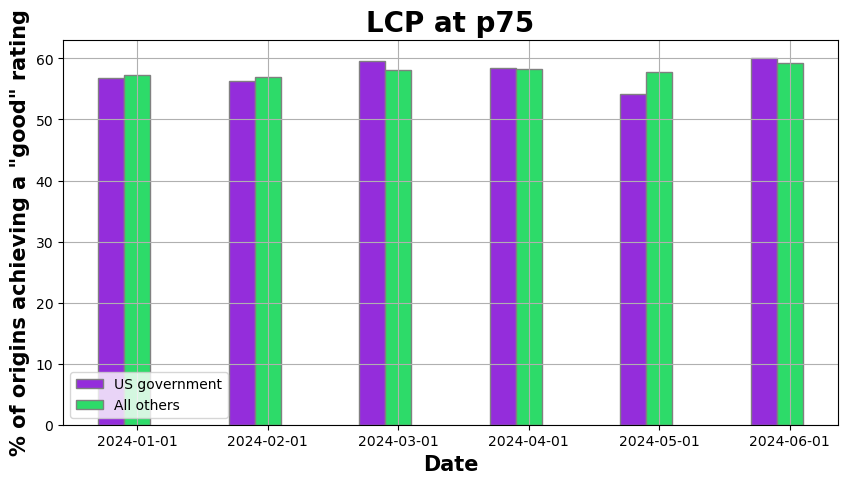

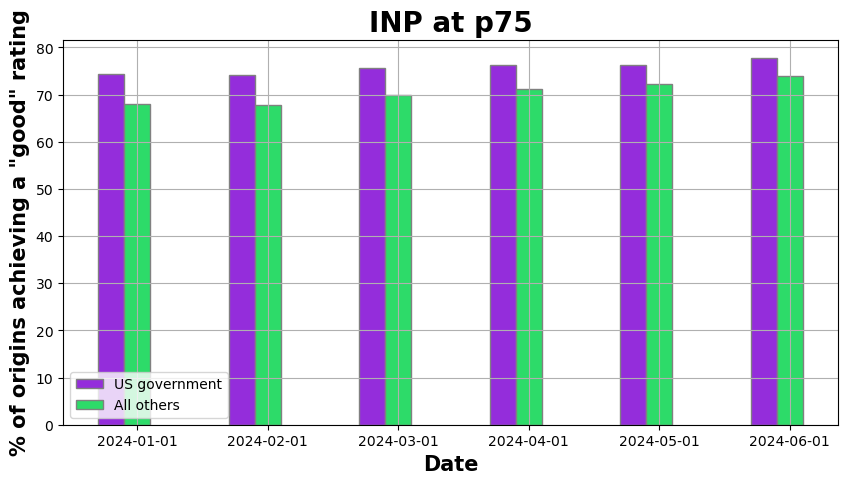

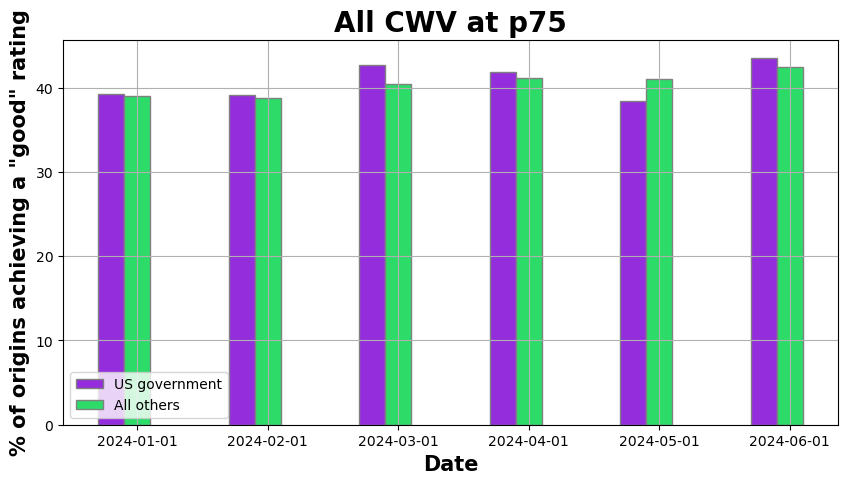

In [211]:
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_cls_dfInGov"],
    merged_df["pct_good_cls_dfNotInGov"],
    "CLS",
    "p75",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_lcp_dfInGov"],
    merged_df["pct_good_lcp_dfNotInGov"],
    "LCP",
    "p75",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_inp_dfInGov"],
    merged_df["pct_good_inp_dfNotInGov"],
    "INP",
    "p75",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_eligible_origins_with_good_cwv_dfInGov"],
    merged_df["pct_eligible_origins_with_good_cwv_dfNotInGov"],
    "All CWV",
    "p75",
)

## Investigation of site data for the 90th-percentile

While the gap between US government sites and other sites was narrow for the percentage of sites receiving a qualitative score of "good" for their data points at the 75th percentile, the gap widens at the 90th percentile, particularly for LCP.

In [212]:
dfNotInGov = load_results_to_dataframe("data/aggregate-cwv-not-in-government-p90.csv")
dfInGov = load_results_to_dataframe("data/aggregate-cwv-in-government-p90.csv")

In [213]:
merged_df = dfNotInGov.join(dfInGov, lsuffix="_dfNotInGov", rsuffix="_dfInGov")
merged_df.head(500)

,client_dfNotInGov,origins_dfNotInGov,origins_with_good_inp_dfNotInGov,origins_with_good_cls_dfNotInGov,origins_with_good_ttfb_dfNotInGov,origins_with_good_fcp_dfNotInGov,origins_with_good_lcp_dfNotInGov,origins_with_any_inp_dfNotInGov,origins_with_any_cls_dfNotInGov,origins_with_any_ttfb_dfNotInGov,...,origins_with_any_fcp_dfInGov,origins_with_any_lcp_dfInGov,origins_with_good_cwv_dfInGov,origins_eligible_for_cwv_dfInGov,pct_good_ttfb_dfInGov,pct_good_fcp_dfInGov,pct_good_lcp_dfInGov,pct_good_cls_dfInGov,pct_good_inp_dfInGov,pct_eligible_origins_with_good_cwv_dfInGov
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,mobile,17608211,2630326,6379769,1913560,2266296,2803785,8478610,11325194,10860991,...,3744,3695,271,3694,0.057235,0.084402,0.179702,0.647232,0.342942,0.065263
2024-02-01,mobile,17772904,2591319,6311483,1854637,2182172,2729704,8428004,11214265,10779924,...,3763,3707,249,3705,0.055585,0.080521,0.175614,0.638615,0.337600,0.061836
2024-03-01,mobile,17684179,2762074,6353281,1849656,2221981,2806932,8390686,11145597,10692326,...,3791,3736,299,3735,0.047682,0.083355,0.183619,0.658569,0.376373,0.074200
2024-04-01,mobile,17718149,2923169,6415912,1835837,2230126,2817353,8383618,11157601,10695393,...,3810,3756,316,3756,0.050119,0.084514,0.180511,0.666141,0.397935,0.076904
2024-05-01,mobile,17729471,3031415,6420265,1796548,2139783,2743646,8409052,11202836,10725682,...,3834,3767,234,3766,0.044568,0.073031,0.150783,0.648288,0.390842,0.058176
2024-06-01,mobile,17550222,3182664,6430983,1776892,2294946,2887778,8346080,11131533,10644873,...,3778,3738,314,3738,0.046996,0.089465,0.185126,0.659597,0.418349,0.077144


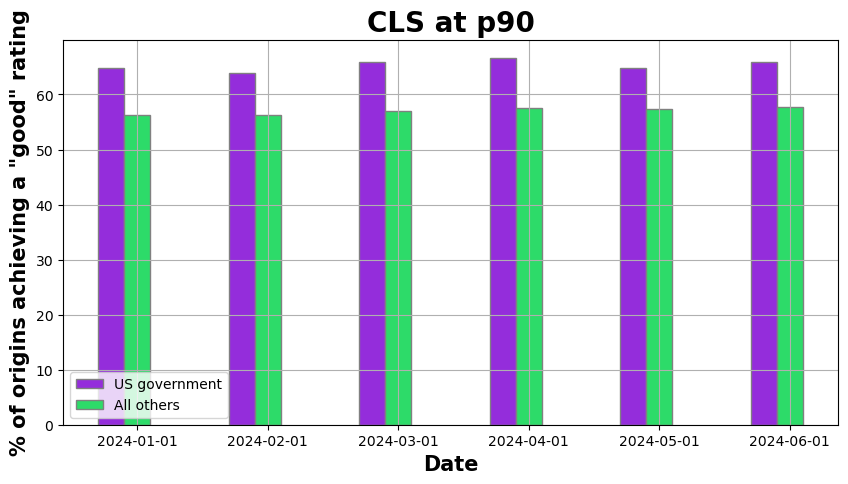

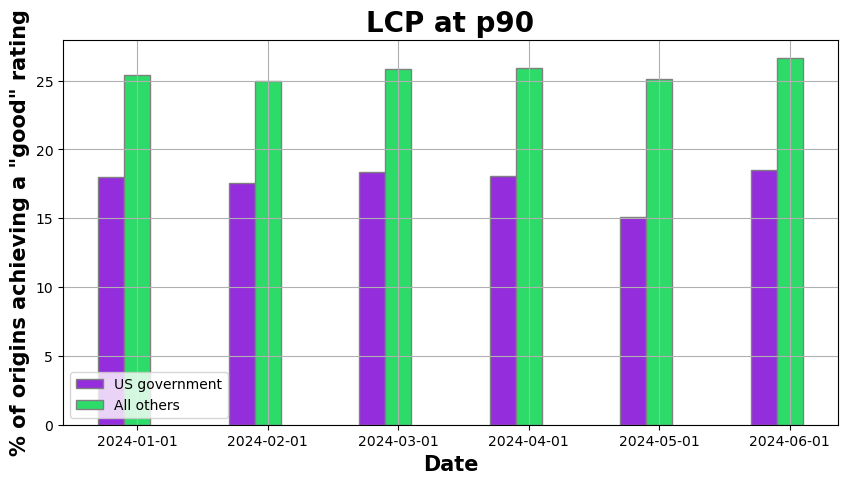

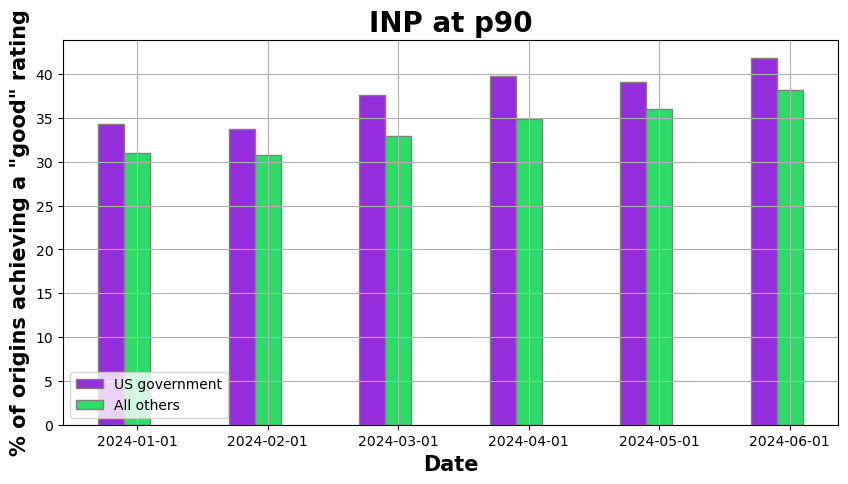

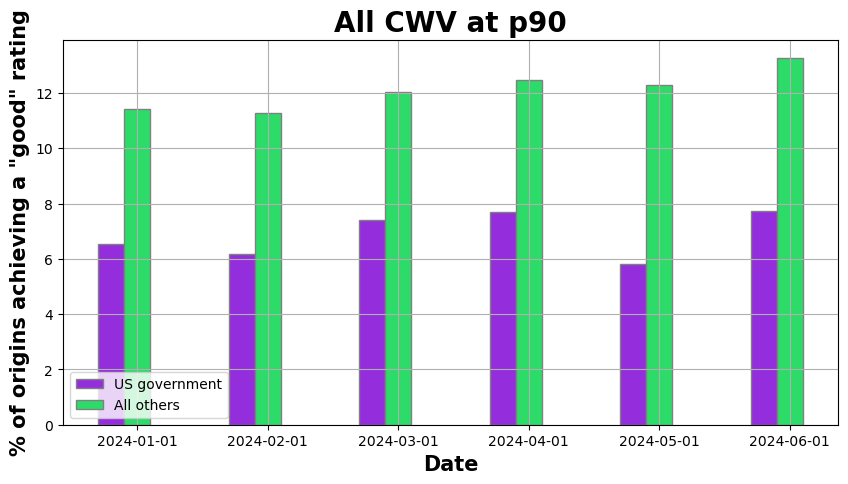

In [215]:
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_cls_dfInGov"],
    merged_df["pct_good_cls_dfNotInGov"],
    "CLS",
    "p90",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_lcp_dfInGov"],
    merged_df["pct_good_lcp_dfNotInGov"],
    "LCP",
    "p90",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_good_inp_dfInGov"],
    merged_df["pct_good_inp_dfNotInGov"],
    "INP",
    "p90",
)
plot_individual_metric_comparison(
    merged_df,
    merged_df["pct_eligible_origins_with_good_cwv_dfInGov"],
    merged_df["pct_eligible_origins_with_good_cwv_dfNotInGov"],
    "All CWV",
    "p90",
)